# Forecasting in Aquaponics

Libraries and setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import sys

os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ["CUDA_VISIBLE_DEVICES"] = "2" 

# np.set_printoptions(threshold=sys.maxsize)

mpl.rcParams['figure.figsize'] = (14, 8)
mpl.rcParams['axes.grid'] = True

np.random.seed(10)

## Data adquisition

### Data adquisition

In [2]:
def read_file(textfile):
    df = pd.read_csv(textfile, compression='zip', sep="\t")
    df.drop(df.columns[0], axis=1, inplace=True)
    print('Dataset ready')
    return df

textfile = "dataset_aquaponics_03012021_05222021.txt.zip"
df = read_file(textfile)

Dataset ready


Organize data in columns

In [3]:

df_grouped = pd.pivot_table(df, index = 'DateTime', columns = 'Label', values = 'Value')
df_grouped.index = pd.to_datetime(df_grouped.index)

start_date = pd.to_datetime('2021-04-01 00:00:00')
end_date = pd.to_datetime('2021-04-17 23:59:59')

df_grouped = df_grouped.loc[start_date:end_date]
print(df_grouped.head())

Label                      1         2    3       4       5          6    \
DateTime                                                                   
2021-04-01 00:00:12  20.880000  51.34556  0.0  6.6498  6.6667  44.003500   
2021-04-01 00:00:38  20.822498  51.09667  0.0  6.6498  6.6667  44.007060   
2021-04-01 00:01:04  20.853998  51.17500  0.0  6.6514  6.6681  43.999874   
2021-04-01 00:05:57  20.928003  50.80000  0.0  6.6584  6.6718  43.621853   
2021-04-01 00:06:23  21.000000  50.68667  0.0  6.6596  6.6731  42.650578   

Label                      7       8       9       10   ...       107  \
DateTime                                                ...             
2021-04-01 00:00:12  49.062016  99.262  95.587  11.690  ...  50.53125   
2021-04-01 00:00:38  49.063637  99.262  95.587  11.690  ...  50.53125   
2021-04-01 00:01:04  49.068360  99.255  95.599  11.687  ...  52.50001   
2021-04-01 00:05:57  49.068610  99.289  95.774  11.615  ...  52.50001   
2021-04-01 00:06:23  49.07313

Data visualization

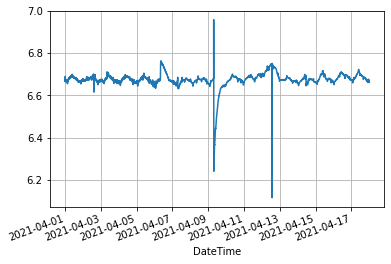

In [4]:
sample_sensor = 5

df_grouped[sample_sensor].plot(x = 'DateTime', y = 'Value', kind = 'line')
plt.xticks(rotation=20)
plt.show()

## Data Pre-processing

### Selecting target 

Target variables:

* 4     = pH sump B
* 5     = pH sump A
* 8     = % oxygen B
* 9     = % oxygen A
* 93*   = Weight cell 1
* 99*   = Nitrate B 
* 100*  = Ammonia B
* 103*  = Nitrate A 
* 104*  = Ammonia A
* sensors are not online yet*

In [5]:
label_target = {
# 4: 'pH sump B',
5: 'pH sump A',}
# 8: '% oxygen B',}
# 9: '% oxygen A'}

### Select features - Human knowledge

In [6]:
drop_signal = [3, 12, 13, 14, 15, 22, 23, 24, 25, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 56, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 93, 94, 95, 97, 98, 99, 100, 101, 104, 105, 106, 111, 112, 113, 114]
df_grouped  = df_grouped.drop(columns = drop_signal)
print(df_grouped.head())

Label                      1         2       4       5          6    \
DateTime                                                              
2021-04-01 00:00:12  20.880000  51.34556  6.6498  6.6667  44.003500   
2021-04-01 00:00:38  20.822498  51.09667  6.6498  6.6667  44.007060   
2021-04-01 00:01:04  20.853998  51.17500  6.6514  6.6681  43.999874   
2021-04-01 00:05:57  20.928003  50.80000  6.6584  6.6718  43.621853   
2021-04-01 00:06:23  21.000000  50.68667  6.6596  6.6731  42.650578   

Label                      7       8       9       10      11   ...    91   \
DateTime                                                        ...          
2021-04-01 00:00:12  49.062016  99.262  95.587  11.690  13.552  ...  406.0   
2021-04-01 00:00:38  49.063637  99.262  95.587  11.690  13.552  ...  406.0   
2021-04-01 00:01:04  49.068360  99.255  95.599  11.687  13.528  ...  406.0   
2021-04-01 00:05:57  49.068610  99.289  95.774  11.615  13.512  ...  406.0   
2021-04-01 00:06:23  49.073135  99

### Denoising dataframe - FFT filter

Check sampling frecuency

In [7]:
sampling_time = df_grouped.index.to_series().diff().median()
print(sampling_time)

0 days 00:00:26


Design sample filter

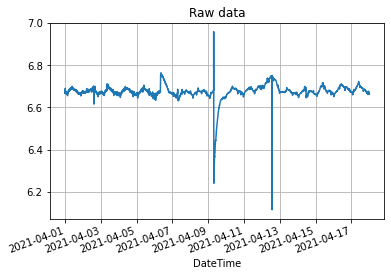

(28636, 46)


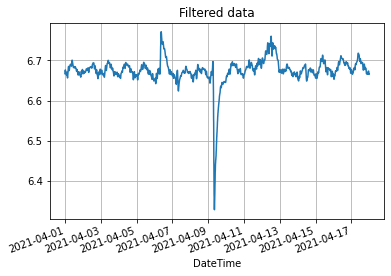

In [8]:
def f_filtering(df, cutt_fc):
    
    new_df = df.copy() 
    index = df.index
    
    dt = 25 # seconds
    n_samples = new_df.shape[0]
    
    # Fast Fourier transform
    f_hat = np.fft.fft(df.to_numpy())
    f_mag_2 = np.real(f_hat * np.conj(f_hat)) / n_samples
    fc_df = (1 / (dt * n_samples)) * np.arange(n_samples)
    
    # Cutting frecuency
    ind_filter = f_mag_2 > cutt_fc
    
    # Filter signal
    f_hat_clean = f_hat * ind_filter
    filter_signal = np.fft.ifft(f_hat_clean)
    
    
    filter_signal = np.real(filter_signal)
    
    return filter_signal

df_grouped[sample_sensor].plot(x = 'DateTime', y = 'Value', kind = 'line')
plt.xticks(rotation=20)
plt.title('Raw data')
plt.show()

# Cutting frecuency
cutt_fc = {
1: 5,   
2: 150,     
4: 0.001,   
5: 0.005,   
6: 25,   
7: 25,   
8: 1,   
9: 1,  
10: 0.1,  
11: 0.1,  
16: 0.1,  
17: 0.1,
18: 500,  
19: 5,  
20: 20,  
21: 20, 
102: 10, 
103: 50}

df_clean = df_grouped.copy()

for sensor in cutt_fc:
    df_clean[sensor] = f_filtering(df_grouped[sensor], cutt_fc[sensor])
    
print(df_clean.shape)

df_clean[sample_sensor].plot(x = 'DateTime', y = 'Value', kind = 'line')
plt.xticks(rotation=20)
plt.title('Filtered data')
plt.show()

### Feature selection via correlation analysis

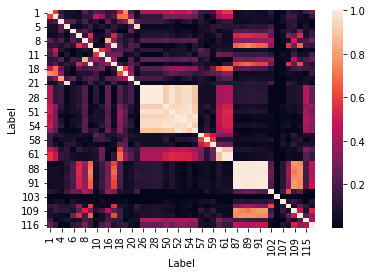

In [9]:
corr_mat = np.abs(df_clean.corr(method='pearson'))
sns.heatmap(corr_mat)
plt.show()

corr_thl = 0.1
corr_label = np.zeros(df_grouped.shape[1])

for i in label_target:
    corr_label = corr_label | (corr_mat[i] > corr_thl)

df_clean = df_clean.loc[:, corr_label]

Describe  dataset

In [10]:
print(df_clean.describe().transpose())

         count         mean         std          min          25%  \
Label                                                               
4      28636.0     6.664216    0.050368     6.559691     6.636648   
5      28636.0     6.675076    0.033121     6.328707     6.666254   
9      28636.0    96.048075    4.577596    88.751129    92.966986   
17     28636.0    10.101525    0.500796     9.151747     9.751985   
20     28636.0    10.902294    7.679193    -1.993669     4.970288   
21     28636.0     6.610800    6.556325    -1.492146     3.409159   
59     28636.0    31.409415   90.516194     0.000000     0.000000   
60     28636.0   121.599944  188.810537     0.000000     0.000000   
61     28636.0   180.245425  233.206339     0.000000     0.000000   
62     28636.0   180.245425  233.206339     0.000000     0.000000   
87     28636.0  1356.293721   10.510800  1339.000000  1347.000000   
89     28636.0   386.400894    6.437937   377.000000   381.000000   
90     28636.0   345.357592    5.8

## Split dataset: train, validation and test

In [11]:
total_data = len(df_clean)

train_perc, val_perc, test_perc = 0.7, 0.2, 0.1

train_df    = df_clean[0:int(total_data*train_perc)]
val_df      = df_clean[int(total_data*train_perc):int(total_data*(train_perc + val_perc))]
test_df     = df_clean[int(total_data*(train_perc + val_perc)):total_data]

## Data normalization

Min-max normalization

In [12]:
def f_normalize_minmax(no_norm_df, df):
    norm_df = (no_norm_df - df.min()) / (df.max() - df.min())
    return norm_df

def f_inv_normalize_minmax(norm_df, train_df):
    df = norm_df * (train_df.max() - train_df.min()) + train_df.min()
    return df

norm_train_df   = f_normalize_minmax(train_df, df_clean)
norm_val_df     = f_normalize_minmax(val_df, df_clean)
norm_test_df    = f_normalize_minmax(test_df, df_clean)

Show tails with box plot

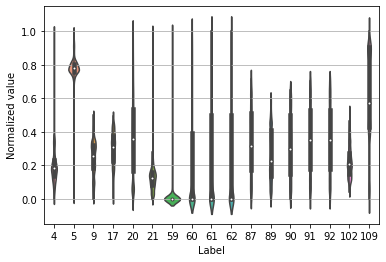

In [13]:
melt_train_df = norm_train_df.melt(var_name = 'Label', value_name = 'Normalized value')
plt.figure()
ax = sns.violinplot(x = 'Label', y = 'Normalized value', data = melt_train_df)
plt.show()

Plot normalized data

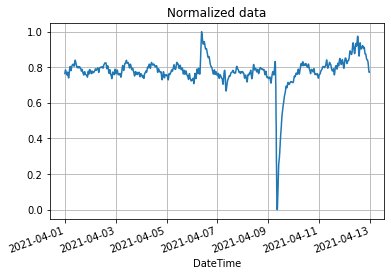

In [14]:
norm_train_df[sample_sensor].plot(x = 'DateTime', y = 'Value', kind = 'line')
plt.xticks(rotation=20)
plt.title('Normalized data')
plt.show()

## Create input and target dataframe - Window generation

In [15]:
n_hour_data = 65 # 65 entries ~ 1 hour - There is a variable sampling frecuency
n_hours_in  = 3
n_hours_out = 1

input_width     = n_hour_data * n_hours_in 
label_width     = n_hour_data * n_hours_out 
offset_width    = 1 # 1 as default

def f_window_gen(df, label_target, input_width, label_width, offset_width):

    time_range = df.index
    data = []
    target = []

    data_time = []
    target_time = []

    for i in range(len(time_range) - (input_width + offset_width + label_width)):
        range_data = df.loc[time_range[i]:time_range[input_width + i]].values
        data.append(range_data)
        data_time.append(time_range[i:input_width + i])

        range_target = df[label_target].loc[time_range[input_width + offset_width + i: input_width + offset_width + label_width + i]].values
        target.append(range_target.flatten('F'))
        target_time.append(time_range[input_width + offset_width + i: input_width + offset_width + label_width + i])

    data = np.array(data)
    target = np.array(target)

    return data, target, data_time, target_time

train_data, train_target, train_data_time, train_target_time = f_window_gen(norm_train_df, label_target, input_width, label_width, offset_width)
val_data, val_target, val_data_time, val_target_time = f_window_gen(norm_val_df, label_target, input_width, label_width, offset_width)
test_data, test_target, test_data_time, test_target_time = f_window_gen(norm_test_df, label_target, input_width, label_width, offset_width)

Plotting - Normalized values

In [137]:
def plot_results(label_target, label_time, label, results, label_width):
    n_label = np.int(len(label_target))

    sensor_tag = list(label_target.values())
    
    fig, ax = plt.subplots(n_label, sharex = 'all')
    
    for i in range(n_label):

        label_plot = label[((i) * label_width): ((i + 1)* label_width)]
        ax.plot(label_time, label_plot, color = 'blue', label = 'Real')
        
        results_plot = results[((i) * label_width): ((i + 1)* label_width)]
        ax.plot(label_time, results_plot, color = 'orange', label = 'Prediction')

        ax.set_ylabel(sensor_tag[i])

    lines, labels = fig.axes[-1].get_legend_handles_labels()
    fig.legend(lines, labels, loc = 'center right')
    plt.xticks(rotation=20)
    plt.xlabel('Day - Time')
    plt.ylim([0.8, 0.9])
    plt.show()

    pass

### Plotting - History

In [138]:
def plot_history(history):

    acc = history.history['mean_absolute_error']
    val_acc = history.history['val_mean_absolute_error']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

#     fig, ax = plt.subplots(1, sharex = 'all')

    # Plot training and validation accuracy per epoch
#     ax[0].plot(epochs, acc, label = 'Training')
#     ax[0].plot(epochs, val_acc, label = 'Validation')
#     ax[0].title.set_text('Training and validation MAE loss')

    # Plot training and validation loss per epoch
    plt.plot(epochs, loss, label = 'Training')
    plt.plot(epochs, val_loss, label = 'Validation')
    plt.title('Training and validation MSE loss')

#     lines, labels = fig.axes[-1].get_legend_handles_labels()
#     fig.legend(lines, labels, loc = 'center right')
    plt.xticks(rotation=20)
    plt.xlabel('epochs')
    plt.show()

## Architecture and Deployment

Callbacks

In [139]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.9

Training method

In [233]:
def compile_and_fit(model, train_data, train_target, val_data, val_target, 
                    test_data, test_target, max_epochs, batch_size, test_entry, label_width):

    # Add callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 3)
    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 0)
    callbacks = [early_stop, lr_scheduler]

    # Model compile
    model.compile(loss      = tf.losses.MeanSquaredError(),
                  optimizer = tf.keras.optimizers.Nadam(),
                  metrics   = [tf.metrics.MeanAbsoluteError()])

    # Model fit
    history = model.fit(train_data,
                        train_target,
                        batch_size = batch_size,
                        epochs  = max_epochs,
                        verbose = 1,
                        shuffle = False, 
                        validation_data = (val_data, val_target),
                        callbacks = callbacks)

    model.summary()
    
    # Model evaluate
    loss_eval, metric_eval = model.evaluate(test_data, test_target, verbose = 0)
    print("Evaluation loss: {} ---- Evaluation metric:{}".format(loss_eval, metric_eval))

    # Test model
    test_data = np.reshape(test_data[test_entry], (1, test_data[0].shape[0], test_data[0].shape[1]))
    test_prediction = model.predict(test_data)
    
    test_prediction = np.squeeze(test_prediction)
    
    # Plot results
    plot_results(label_target, test_target_time[test_entry], test_target[test_entry], test_prediction, label_width)

    plot_history(history)

    return history, test_prediction

test_entry = np.random.randint(0, 100)

# Models

## Linear model

In [133]:
def f_linear_model(label_target, label_width):
    model = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
        
#             tf.keras.layers.Dense(units = 300, kernel_initializer='random_normal', bias_initializer='zeros'),
#             tf.keras.layers.Dropout(0.2),
            
            tf.keras.layers.Dense(units = 400, kernel_initializer='random_normal', bias_initializer='zeros'),
#             tf.keras.layers.Dropout(0.1),
        
            tf.keras.layers.Dense(units = 200, kernel_initializer='random_normal', bias_initializer='zeros'),
#             tf.keras.layers.Dropout(0.1),
        
            tf.keras.layers.Dense(units = len(label_target) * label_width)])
    return model

linear_model = f_linear_model(label_target, label_width)

Train on 19784 samples, validate on 5466 samples
Epoch 1/30
19784/19784 [==============================] - 2s 86us/sample - loss: 1.4971 - mean_absolute_error: 0.8180 - val_loss: 1.7039 - val_mean_absolute_error: 0.9988
Epoch 2/30
19784/19784 [==============================] - 1s 50us/sample - loss: 0.1637 - mean_absolute_error: 0.2241 - val_loss: 0.9853 - val_mean_absolute_error: 0.7910
Epoch 3/30
19784/19784 [==============================] - 1s 50us/sample - loss: 0.0683 - mean_absolute_error: 0.1443 - val_loss: 0.7380 - val_mean_absolute_error: 0.6779
Epoch 4/30
19784/19784 [==============================] - 1s 49us/sample - loss: 0.0506 - mean_absolute_error: 0.1186 - val_loss: 0.6395 - val_mean_absolute_error: 0.6410
Epoch 5/30
19784/19784 [==============================] - 1s 51us/sample - loss: 0.0368 - mean_absolute_error: 0.1026 - val_loss: 0.5644 - val_mean_absolute_error: 0.6144
Epoch 6/30
19784/19784 [==============================] - 1s 49us/sample - loss: 0.0313 - mean_a

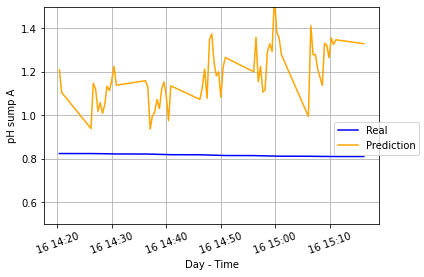

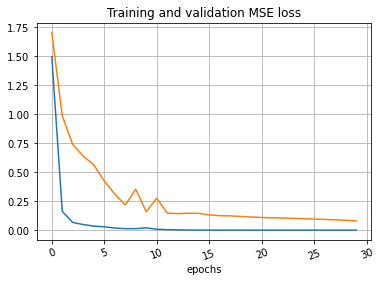

In [134]:
max_epochs = 30
batch_size = 100

linear_history, linear_prediction = compile_and_fit(linear_model, train_data, train_target, val_data, val_target, 
                                                    test_data, test_target, max_epochs, batch_size, test_entry, label_width)

## MLP model

In [173]:
def f_mlp_model(label_target, label_width):
    model = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
        
#             tf.keras.layers.Dense(units = 800, activation = 'relu', kernel_initializer='random_normal', bias_initializer='zeros'),
#             tf.keras.layers.Dropout(0.2),
        
            tf.keras.layers.Dense(units = 200, activation = 'relu', kernel_initializer='random_normal', bias_initializer='zeros'),
            tf.keras.layers.Dropout(0.2),
        
            tf.keras.layers.Dense(units = 100, activation = 'relu', kernel_initializer='random_normal', bias_initializer='zeros'),
            tf.keras.layers.Dropout(0.2),

        
            tf.keras.layers.Dense(units = len(label_target) * label_width)])
    return model
    
mlp_model = f_mlp_model(label_target, label_width)

Train on 19784 samples, validate on 5466 samples
Epoch 1/30
19784/19784 [==============================] - 2s 94us/sample - loss: 0.1187 - mean_absolute_error: 0.2646 - val_loss: 0.0276 - val_mean_absolute_error: 0.1409
Epoch 2/30
19784/19784 [==============================] - 1s 51us/sample - loss: 0.0287 - mean_absolute_error: 0.1330 - val_loss: 0.0307 - val_mean_absolute_error: 0.1467
Epoch 3/30
19784/19784 [==============================] - 1s 52us/sample - loss: 0.0224 - mean_absolute_error: 0.1143 - val_loss: 0.0057 - val_mean_absolute_error: 0.0611
Epoch 4/30
19784/19784 [==============================] - 1s 52us/sample - loss: 0.0120 - mean_absolute_error: 0.0770 - val_loss: 0.0100 - val_mean_absolute_error: 0.0958
Epoch 5/30
19784/19784 [==============================] - 1s 53us/sample - loss: 0.0105 - mean_absolute_error: 0.0708 - val_loss: 0.0101 - val_mean_absolute_error: 0.0960
Epoch 6/30
19784/19784 [==============================] - 1s 52us/sample - loss: 0.0101 - mean_a

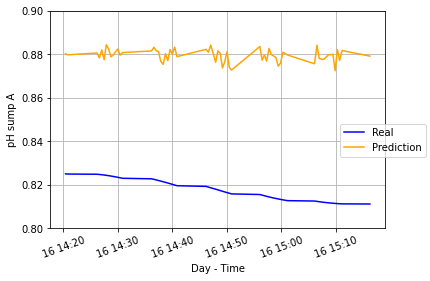

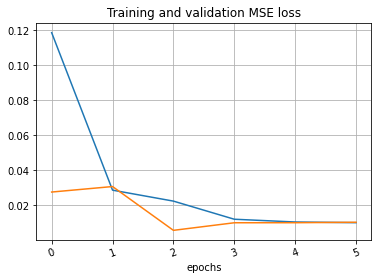

In [174]:
max_epochs = 30
batch_size = 100
mlp_history, mlp_prediction = compile_and_fit(mlp_model, train_data, train_target, val_data, val_target, 
                                              test_data, test_target, max_epochs, batch_size, test_entry, label_width)

## LSTM RNN model

In [244]:
def f_lstm_model(input_shape, output_shape):
    model = tf.keras.Sequential([
            
            tf.keras.layers.LSTM(units = 800, input_shape = input_shape, kernel_initializer='random_normal', bias_initializer='zeros', dropout=0.2, return_sequences=True),
    
            tf.keras.layers.LSTM(units = 50, input_shape = input_shape, kernel_initializer='random_normal', bias_initializer='zeros', dropout=0.2, return_sequences=False),
            tf.keras.layers.Dense(output_shape)])
    return model

input_shape = train_data[0].shape
output_shape = train_target.shape[1]
lstm_model = f_lstm_model(input_shape, output_shape)

Train on 19784 samples, validate on 5466 samples
Epoch 1/20
19784/19784 [==============================] - 33s 2ms/sample - loss: 0.0152 - mean_absolute_error: 0.0497 - val_loss: 0.0036 - val_mean_absolute_error: 0.0532
Epoch 2/20
19784/19784 [==============================] - 29s 1ms/sample - loss: 0.0027 - mean_absolute_error: 0.0236 - val_loss: 0.0035 - val_mean_absolute_error: 0.0529
Epoch 3/20
19784/19784 [==============================] - 29s 1ms/sample - loss: 0.0028 - mean_absolute_error: 0.0233 - val_loss: 0.0034 - val_mean_absolute_error: 0.0519
Epoch 4/20
19784/19784 [==============================] - 29s 1ms/sample - loss: 0.0028 - mean_absolute_error: 0.0235 - val_loss: 0.0034 - val_mean_absolute_error: 0.0518
Epoch 5/20
19784/19784 [==============================] - 29s 1ms/sample - loss: 0.0029 - mean_absolute_error: 0.0238 - val_loss: 0.0034 - val_mean_absolute_error: 0.0519
Epoch 6/20
19784/19784 [==============================] - 29s 1ms/sample - loss: 0.0030 - mean_a

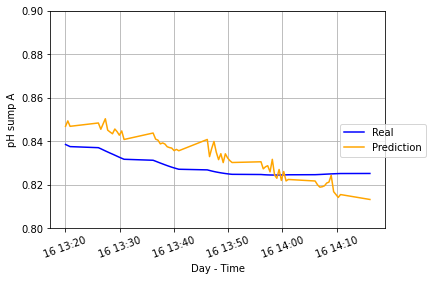

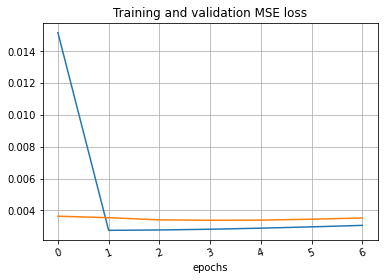

In [245]:
max_epochs = 20
batch_size = 50
lstm_history, lstm_prediction = compile_and_fit(lstm_model, train_data, train_target, val_data, val_target, 
                                                test_data, test_target, max_epochs, batch_size, test_entry, label_width)

## GRU RNN model 

In [260]:
def f_gru_model(input_shape, output_shape):
    model = tf.keras.Sequential([
            tf.keras.layers.GRU(units = 800, input_shape = input_shape, kernel_initializer='random_normal', bias_initializer='zeros', dropout=0.2, return_sequences=True),
        
            tf.keras.layers.GRU(units = 300, input_shape = input_shape, kernel_initializer='random_normal', bias_initializer='zeros', dropout=0.2, return_sequences=True),
        
            tf.keras.layers.GRU(units = 60, input_shape = input_shape, kernel_initializer='random_normal', bias_initializer='zeros', dropout=0.2, return_sequences=False),

            tf.keras.layers.Dense(output_shape)])
    return model

input_shape = train_data[0].shape
output_shape = train_target.shape[1]
gru_model = f_gru_model(input_shape, output_shape)

Train on 19784 samples, validate on 5466 samples
Epoch 1/20
19784/19784 [==============================] - 39s 2ms/sample - loss: 0.0111 - mean_absolute_error: 0.0444 - val_loss: 0.0033 - val_mean_absolute_error: 0.0479
Epoch 2/20
19784/19784 [==============================] - 34s 2ms/sample - loss: 0.0032 - mean_absolute_error: 0.0237 - val_loss: 0.0034 - val_mean_absolute_error: 0.0506
Epoch 3/20
19784/19784 [==============================] - 34s 2ms/sample - loss: 0.0026 - mean_absolute_error: 0.0227 - val_loss: 0.0033 - val_mean_absolute_error: 0.0499
Epoch 4/20
19784/19784 [==============================] - 34s 2ms/sample - loss: 0.0027 - mean_absolute_error: 0.0232 - val_loss: 0.0033 - val_mean_absolute_error: 0.0503
Epoch 5/20
19784/19784 [==============================] - 34s 2ms/sample - loss: 0.0028 - mean_absolute_error: 0.0234 - val_loss: 0.0033 - val_mean_absolute_error: 0.0504
Epoch 6/20
19784/19784 [==============================] - 34s 2ms/sample - loss: 0.0037 - mean_a

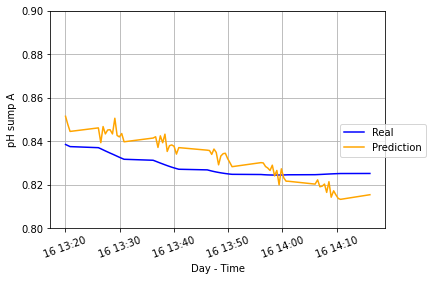

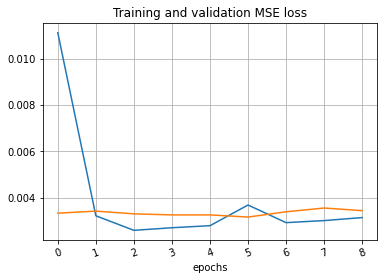

In [261]:
max_epochs = 20
batch_size = 50
gru_history, gru_prediction = compile_and_fit(gru_model, train_data, train_target, val_data, val_target, 
                                              test_data, test_target, max_epochs, batch_size, test_entry, label_width)

In [262]:
def plot_results2(label_target, label_time, label, results, label_width):
    n_label = np.int(len(label_target))

    sensor_tag = list(label_target.values())
    
    fig, ax = plt.subplots(n_label, sharex = 'all')
    
    for i in range(n_label):

        label_plot = label[((i) * label_width): ((i + 1)* label_width)]
        ax.plot(label_time, label_plot, color = 'blue', label = 'Real')
        
        results_plot = results[((i) * label_width): ((i + 1)* label_width)]
        ax.plot(label_time, results_plot, color = 'orange', label = 'Prediction')

        ax.set_ylabel(sensor_tag[i])

    lines, labels = fig.axes[-1].get_legend_handles_labels()
    fig.legend(lines, labels, loc = 'center right')
    plt.xticks(rotation=20)
    plt.xlabel('Day - Time')
    plt.ylim([0.78, 0.88])
    plt.show()

    pass

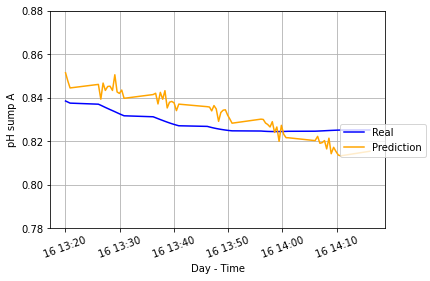

In [263]:
plot_results2(label_target, test_target_time[test_entry], test_target[test_entry], gru_prediction, label_width)

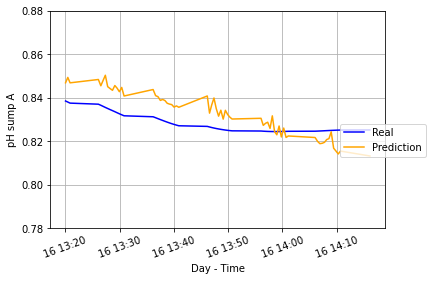

In [264]:
plot_results2(label_target, test_target_time[test_entry], test_target[test_entry], lstm_prediction, label_width)

In [271]:
def plot_results3(label_target, label_time, label, results_linear, results_mlp, results_lstm, results_gru, label_width):
    n_label = np.int(len(label_target))

    sensor_tag = list(label_target.values())
    
    fig, ax = plt.subplots(n_label, sharex = 'all')
    
    for i in range(n_label):

        label_plot = label[((i) * label_width): ((i + 1)* label_width)]
        ax.plot(label_time, label_plot, color = 'blue', label = 'Real')
        
#         results_plot_linear = results_linear[((i) * label_width): ((i + 1)* label_width)]
#         ax.plot(label_time, results_plot_linear, color = 'orange', label = 'Linear')
        
        results_plot_mlp = results_mlp[((i) * label_width): ((i + 1)* label_width)]
        ax.plot(label_time, results_plot_mlp, color = 'purple', label = 'MLP')
        
        results_plot_lstm = results_lstm[((i) * label_width): ((i + 1)* label_width)]
        ax.plot(label_time, results_plot_lstm, color = 'black', label = 'LSTM')
        
        results_plot_gru = results_gru[((i) * label_width): ((i + 1)* label_width)]
        ax.plot(label_time, results_plot_gru, color = 'green', label = 'GRU')

        ax.set_ylabel(sensor_tag[i])

    lines, labels = fig.axes[-1].get_legend_handles_labels()
    fig.legend(lines, labels, loc = 'center right')
    plt.xticks(rotation=20)
    plt.xlabel('Day - Time')
    plt.ylim([0.8, 0.9])
    plt.show()

    pass

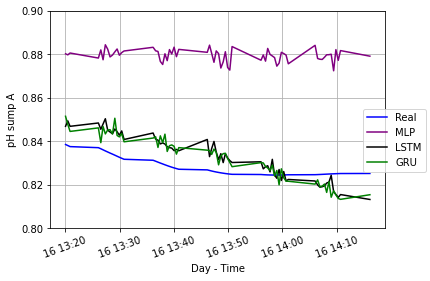

In [272]:
plot_results3(label_target, test_target_time[test_entry], test_target[test_entry], linear_prediction, mlp_prediction, lstm_prediction, gru_prediction, label_width)